### Model devlopment
#### N-BEATS (Neural Basis Expansion Analysis for Time Series )

In [2]:
import pandas as pd
import numpy as np
import darts
import yfinance as yf

# visualization
import matplotlib.pyplot as plt

# timeseries with darts
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.models import NBEATSModel

# RF model test with Covariate
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, rmse, r2_score

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Data preparation for model development

df =pd.read_csv(r'C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\code\Data\final_df.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])


# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)

# split the data into train and validation
train, validation = my_multivariate_series.split_after(0.8)

In [ ]:
# data add Price and Sales data.
msft = yf.Ticker("MSFT")
historical_data = msft.history(start="2019-07-01")
# df.index = df.index.tz_convert(None)
# historical_data.reset_index(inplace=True)
historical_data.index = historical_data.index.tz_convert(None)
# historical_data['Date'] = historical_data.index
historical_data.reset_index(inplace=True)
historical_data.head()
historical_data.info()
h_df = historical_data[['Date', 'Close', 'Volume']]
h_df.head()

In [3]:
# create a list of our conditions
conditions = [
    (h_df['Date'] < '2020-07-01 04:00:00'),
    (h_df['Date'] >= '2020-07-01 04:00:00') & (h_df['Date'] < '2021-07-01 04:00:00'),
    (h_df['Date'] >= '2021-07-01 04:00:00') & (h_df['Date'] < '2022-07-01 04:00:00'),
    (h_df['Date'] >= '2022-07-01 04:00:00') & (h_df['Date'] < '2023-07-01 04:00:00'),
    (h_df['Date'] >= '2023-07-01 04:00:00') 
    ]

# create a list of the values we want to assign for each condition
values = [5.82, 8.12, 9.70, 9.72, 10.37] # 10.37 is TTM

# create a new column and use np.select to assign values to it using our lists as arguments
h_df['EPS'] = np.select(conditions, values)

C:\Users\dicod\AppData\Local\Temp\ipykernel_7484\141539510.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['EPS'] = np.select(conditions, values)


In [4]:
# create a list of our conditions
conditions = [
    (h_df['Date'] < '2020-07-01 04:00:00'),
    (h_df['Date'] >= '2020-07-01 04:00:00') & (h_df['Date'] < '2021-07-01 04:00:00'),
    (h_df['Date'] >= '2021-07-01 04:00:00') & (h_df['Date'] < '2022-07-01 04:00:00'),
    (h_df['Date'] >= '2022-07-01 04:00:00') & (h_df['Date'] < '2023-07-01 04:00:00'),
    (h_df['Date'] >= '2023-07-01 04:00:00') 
    ]

# create a list of the values we want to assign for each condition
values = [143015000000.0, 168088000000.0, 198270000000.0, 211915000000.0, 227583000] # 227583000 is TTM.

# create a new column
h_df['Total Revenue'] = np.select(conditions, values)

C:\Users\dicod\AppData\Local\Temp\ipykernel_7484\1067916035.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df['Total Revenue'] = np.select(conditions, values)


In [5]:
h_df.loc[:,'P/E'] = h_df['Close']/h_df['EPS']
h_df.loc[:,'P/S'] = h_df['Close']/h_df['Total Revenue']

C:\Users\dicod\AppData\Local\Temp\ipykernel_7484\3024552723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df.loc[:,'P/E'] = h_df['Close']/h_df['EPS']
C:\Users\dicod\AppData\Local\Temp\ipykernel_7484\3024552723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_df.loc[:,'P/S'] = h_df['Close']/h_df['Total Revenue']


In [6]:
df = h_df
df.to_csv("final_df.csv", index=False)

In [8]:
df = pd.read_csv("final_df.csv")

In [9]:
# I meet some issue to change the dataframe to TS
#--> my date format is %y-%m-%d %h:%m:%s, so TimeSeries.from_datafram's frequency recognize 'H'.
#but actually TimeSeries.from_datafram's frequency is 'D'.
#that is why I should change the date format.

unique_dates = df['Date'].unique()
print(unique_dates)

['2019-07-01 04:00:00' '2019-07-02 04:00:00' '2019-07-03 04:00:00' ...
 '2024-03-20 04:00:00' '2024-03-21 04:00:00' '2024-03-22 04:00:00']


In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1191 non-null   datetime64[ns]
 1   Close          1191 non-null   float64       
 2   Volume         1191 non-null   int64         
 3   EPS            1191 non-null   float64       
 4   Total Revenue  1191 non-null   float64       
 5   P/E            1191 non-null   float64       
 6   P/S            1191 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 65.3 KB


In [13]:
# time_col = None set, the reason is the weekend value is nan.

ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# we need to scaling all series.

scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

In [15]:
my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)
my_multivariate_series

<TimeSeries (DataArray) (time: 1191, component: 5, sample: 1)>
array([[[1.09393925e-02],
        [1.54780258e-01],
        [0.00000000e+00],
        [2.89131750e-02],
        [1.22925996e-05]],

       [[1.37768664e-02],
        [7.09878612e-02],
        [0.00000000e+00],
        [3.64127123e-02],
        [1.54810702e-05]],

       [[1.65511512e-02],
        [5.27143320e-02],
        [0.00000000e+00],
        [4.37452384e-02],
        [1.85985350e-05]],

       ...,

       [[9.86339140e-01],
        [1.00778769e-01],
        [1.00000000e+00],
        [9.79736015e-01],
        [9.90353487e-01]],

       [[1.00000000e+00],
        [1.39814936e-01],
        [1.00000000e+00],
        [1.00000000e+00],
        [1.00000000e+00]],

       [[9.97921149e-01],
        [9.82385386e-02],
        [1.00000000e+00],
        [9.96916314e-01],
        [9.98532035e-01]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 1184 1185 1186 1187 1188 1189 1190
  * component  (component) object 'Close' 'Volume' 'EPS' 'P/E' 'P/S'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
# split the data into train and validation
train, validation = my_multivariate_series.split_after(0.8)

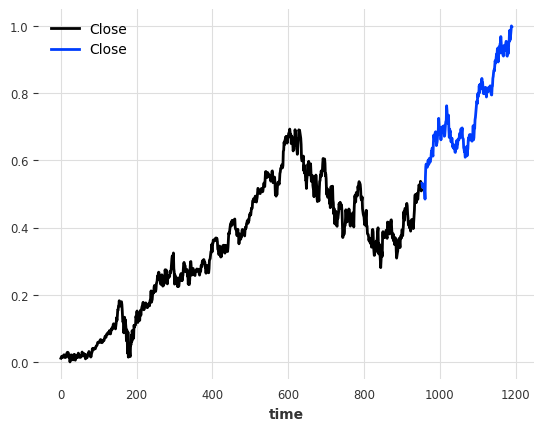

In [17]:
train['Close'].plot()
validation['Close'].plot()

from the paper, N beats model has following key principles.

1. simple, generic, deep architecture.
2. this model's architecture does not rely on ts features like seasonality, trend, pattern.
3. this model is possible to interpretable.

### According to parameter conditions
1. num_stacks = 3, 5, 7, 10
2. num_blocks = 1, 2, 4, 6
3. n_epochs = 10, 20, 30, 40, 50

### According to past_cov
1. technical data
2. fundamental data
3. techical + fundamental

### Model evaluation using validataion data (20% of total) --> historical forecasting and mape, mase.

### N BEATS model implementaion result


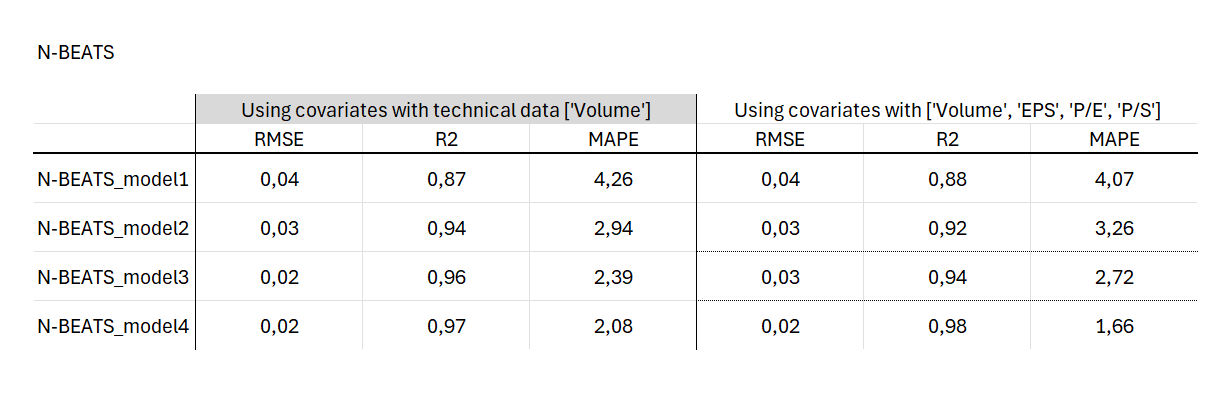

In [18]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.002,
    mode='min',
)
pl_trainer_kwargs={"callbacks": [my_stopper]}

### According to parameter conditions
1. num_stacks = 3, 5, 7, 10
2. num_blocks = 1, 2, 4, 6
3. n_epochs = 10, 20, 30, 50

### According to past_cov
1. technical data
2. fundamental data
3. techical + fundamental

### Model evaluation using validataion data (20% of total) --> historical forecasting and mape, mase.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 648 K 
---------------------------------------------------
646 K     Trainable params
1.6 K     Non-trainable params
648 K     Total params
2.593     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.04
R2 = 0.87
MAPE = 4.26


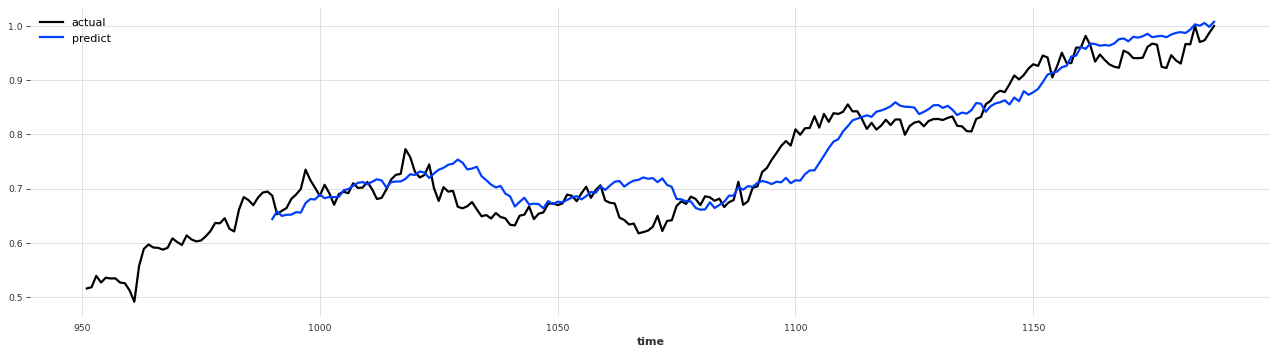

In [76]:
# using train and validation data
past_cov_train = train['Volume']
past_cov_val = validation['Volume']

# model_par1 with num_stack is 3, num_blocks is 1, n_epochs is 10
model_par_1 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=3, num_blocks=1, num_layers=4,
    n_epochs=10,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_1.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m1_val = model_par_1.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m1_val_Close = scaler.inverse_transform(pred_m1_val)
pred_m1_val_Close.values()

pred_series = model_par_1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats_rmse = rmse(validation['Close'], pred_series)
nbeats_r2 = r2_score(validation['Close'], pred_series)
nbeats_mape = mape(validation['Close'], pred_series)
print("RMSE = %.2f" % nbeats_rmse)
print("R2 = %.2f" % nbeats_r2)
print("MAPE = %.2f" % nbeats_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series.plot(label="predict")
plt.show()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.2 M 
---------------------------------------------------
2.2 M     Trainable params
1.6 K     Non-trainable params
2.2 M     Total params
8.642     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.03
R2 = 0.94
MAPE = 2.94


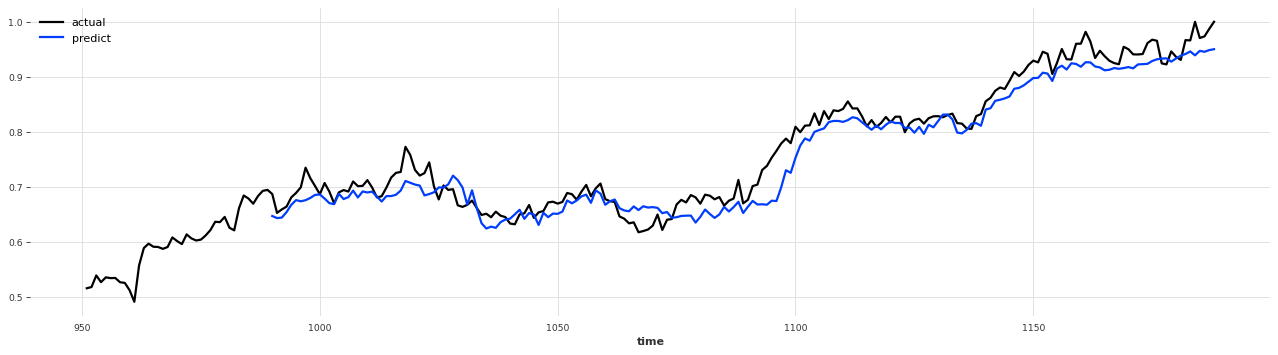

In [75]:
# using train and validation data
past_cov_train = train['Volume']
past_cov_val = validation['Volume']

# model_par2 with num_stack is 5, num_blocks is 2, n_epochs is 20
model_par_2 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=5, num_blocks=2, num_layers=4,
    n_epochs=20,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_2.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m2_val = model_par_2.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m2_val_Close = scaler.inverse_transform(pred_m2_val)
pred_m2_val_Close.values()

pred_series_2 = model_par_2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats2_rmse = rmse(validation['Close'], pred_series_2)
nbeats2_r2 = r2_score(validation['Close'], pred_series_2)
nbeats2_mape = mape(validation['Close'], pred_series_2)

print("RMSE = %.2f" % nbeats2_rmse)
print("R2 = %.2f" % nbeats2_r2)
print("MAPE = %.2f" % nbeats2_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series_2.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.0 M 
---------------------------------------------------
6.0 M     Trainable params
1.6 K     Non-trainable params
6.0 M     Total params
24.197    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.02
R2 = 0.96
MAPE = 2.39


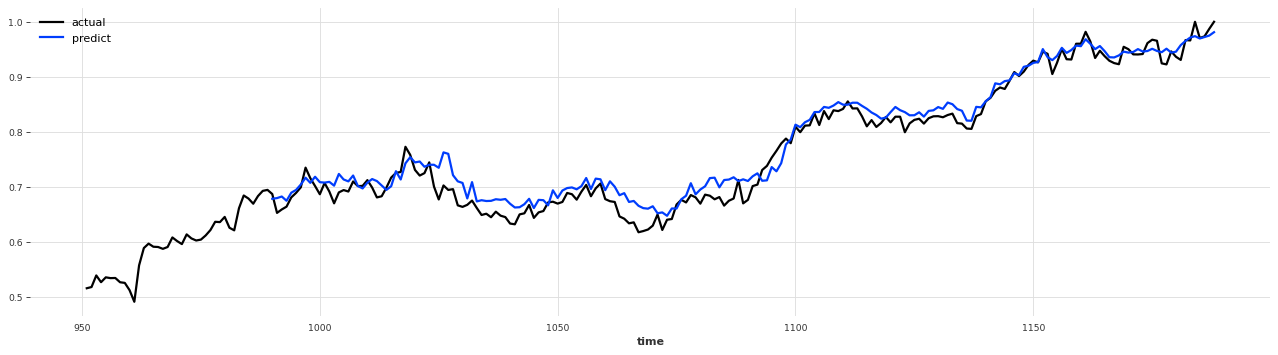

In [74]:
# using train and validation data
past_cov_train = train['Volume']
past_cov_val = validation['Volume']

# model_par3 with num_stack is 7, num_blocks is 4, n_epochs is 30
model_par_3 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=7, num_blocks=4, num_layers=4,
    n_epochs=30,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_3.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m3_val = model_par_3.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m3_val_Close = scaler.inverse_transform(pred_m3_val)
pred_m3_val_Close.values()

pred_series_3 = model_par_3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats3_rmse = rmse(validation['Close'], pred_series_3)
nbeats3_r2 = r2_score(validation['Close'], pred_series_3)
nbeats3_mape = mape(validation['Close'], pred_series_3)

print("RMSE = %.2f" % nbeats3_rmse)
print("R2 = %.2f" % nbeats3_r2)
print("MAPE = %.2f" % nbeats3_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series_3.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 13.0 M
---------------------------------------------------
13.0 M    Trainable params
1.6 K     Non-trainable params
13.0 M    Total params
51.850    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.02
R2 = 0.97
MAPE = 2.08


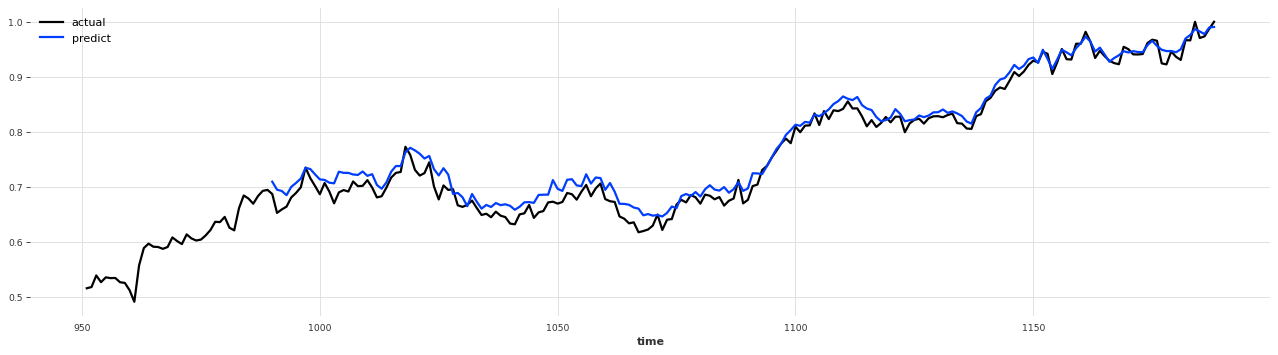

In [73]:
# using train and validation data
past_cov_train = train['Volume']
past_cov_val = validation['Volume']

# model_par4 with num_stack is 10, num_blocks is 6, n_epochs is 50
model_par_4 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=10, num_blocks=6, num_layers=4,
    n_epochs=50,
    activation='LeakyReLU',
    # pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_4.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m4_val = model_par_4.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m4_val_Close = scaler.inverse_transform(pred_m4_val)
pred_m4_val_Close.values()

pred_series_4 = model_par_4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats4_rmse = rmse(validation['Close'], pred_series_4)
nbeats4_r2 = r2_score(validation['Close'], pred_series_4)
nbeats4_mape = mape(validation['Close'], pred_series_4)

print("RMSE = %.2f" % nbeats4_rmse)
print("R2 = %.2f" % nbeats4_r2)
print("MAPE = %.2f" % nbeats4_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series_4.plot(label="predict")
plt.show()

### N BEATS model with covariates['Volume' 'EPS' 'P/E' 'P/S']

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 719 K 
---------------------------------------------------
717 K     Trainable params
2.2 K     Non-trainable params
719 K     Total params
2.878     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.04
R2 = 0.88
MAPE = 4.07


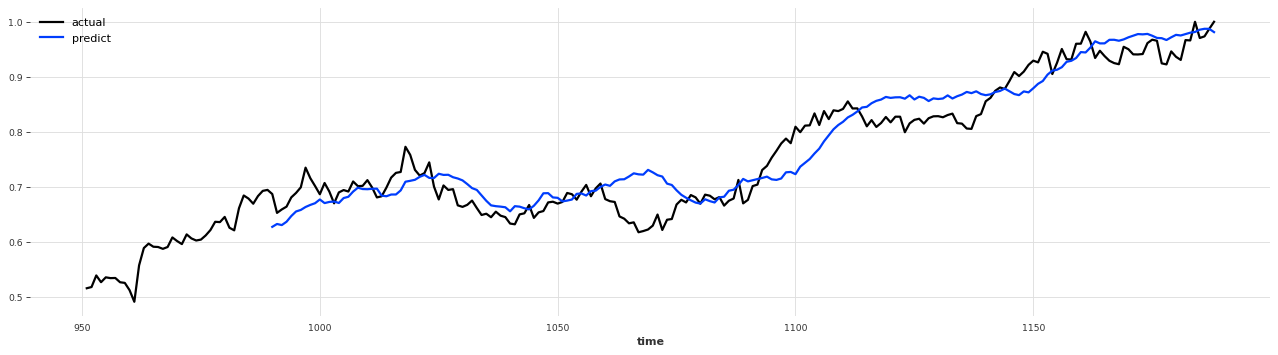

In [77]:
# using train and validation data
past_cov_train = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val = validation[['Volume', 'EPS', 'P/E', 'P/S']]

# model_par1 with num_stack is 3, num_blocks is 1, n_epochs is 10
model_par_1 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=3, num_blocks=1, num_layers=4,
    n_epochs=10,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_1.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m1_val = model_par_1.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m1_val_Close = scaler.inverse_transform(pred_m1_val)
pred_m1_val_Close.values()

pred_series = model_par_1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats_rmse = rmse(validation['Close'], pred_series)
nbeats_r2 = r2_score(validation['Close'], pred_series)
nbeats_mape = mape(validation['Close'], pred_series)
print("RMSE = %.2f" % nbeats_rmse)
print("R2 = %.2f" % nbeats_r2)
print("MAPE = %.2f" % nbeats_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.4 M 
---------------------------------------------------
2.4 M     Trainable params
2.2 K     Non-trainable params
2.4 M     Total params
9.592     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.03
R2 = 0.92
MAPE = 3.26


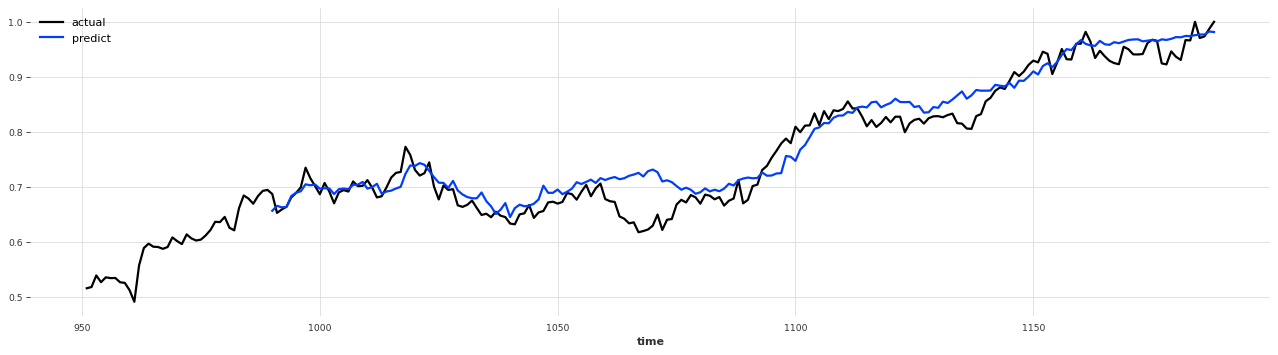

In [80]:
# using train and validation data
past_cov_train = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val = validation[['Volume', 'EPS', 'P/E', 'P/S']]

model_par_2 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=5, num_blocks=2, num_layers=4,
    n_epochs=20,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_2.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m2_val = model_par_2.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m2_val_Close = scaler.inverse_transform(pred_m2_val)
pred_m2_val_Close.values()

pred_series_2 = model_par_2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats2_rmse = rmse(validation['Close'], pred_series_2)
nbeats2_r2 = r2_score(validation['Close'], pred_series_2)
nbeats2_mape = mape(validation['Close'], pred_series_2)

print("RMSE = %.2f" % nbeats2_rmse)
print("R2 = %.2f" % nbeats2_r2)
print("MAPE = %.2f" % nbeats2_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series_2.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.7 M 
---------------------------------------------------
6.7 M     Trainable params
2.2 K     Non-trainable params
6.7 M     Total params
26.858    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.03
R2 = 0.94
MAPE = 2.72


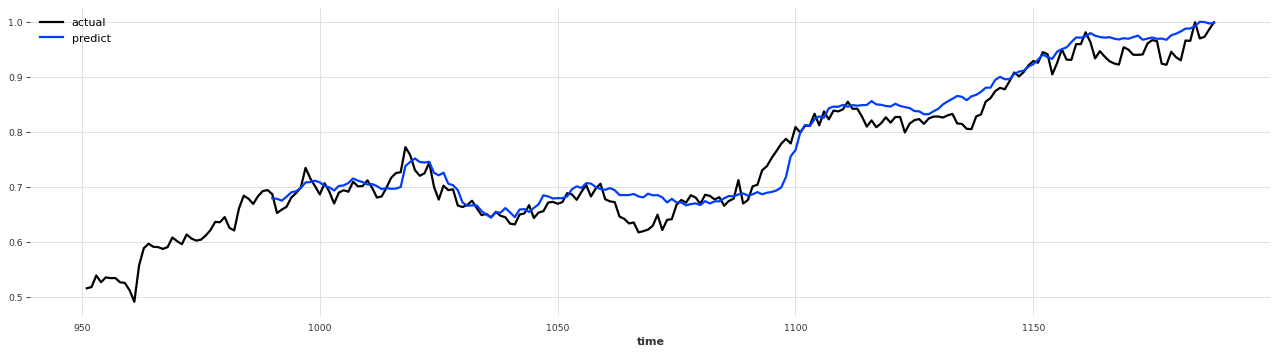

In [79]:
# using train and validation data
past_cov_train = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val = validation[['Volume', 'EPS', 'P/E', 'P/S']]

# model_par3 with num_stack is 7, num_blocks is 4, n_epochs is 30
model_par_3 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=7, num_blocks=4, num_layers=4,
    n_epochs=30,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_3.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m3_val = model_par_3.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m3_val_Close = scaler.inverse_transform(pred_m3_val)
pred_m3_val_Close.values()

pred_series_3 = model_par_3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats3_rmse = rmse(validation['Close'], pred_series_3)
nbeats3_r2 = r2_score(validation['Close'], pred_series_3)
nbeats3_mape = mape(validation['Close'], pred_series_3)

print("RMSE = %.2f" % nbeats3_rmse)
print("R2 = %.2f" % nbeats3_r2)
print("MAPE = %.2f" % nbeats3_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series_3.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 14.4 M
---------------------------------------------------
14.4 M    Trainable params
2.2 K     Non-trainable params
14.4 M    Total params
57.552    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.02
R2 = 0.98
MAPE = 1.66


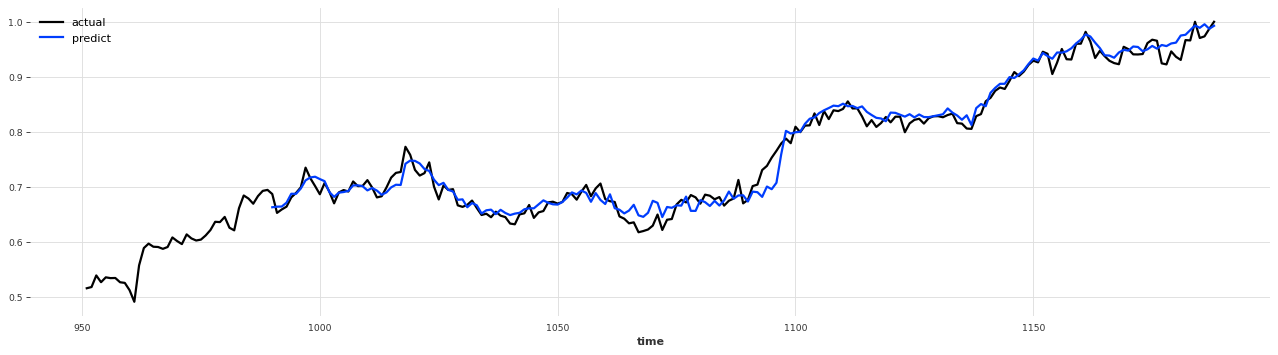

In [71]:
# using train and validation data
past_cov_train = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val = validation[['Volume', 'EPS', 'P/E', 'P/S']]

# model_par4 with num_stack is 10, num_blocks is 6, n_epochs is 50
model_par_4 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=10, num_blocks=6, num_layers=4,
    n_epochs=50,
    activation='LeakyReLU',
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
model_par_4.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train, past_cov_val])

pred_m4_val = model_par_4.predict(
    series=validation['Close'],
    past_covariates=past_cov_val,
    n=10)

pred_m4_val_Close = scaler.inverse_transform(pred_m4_val)
pred_m4_val_Close.values()

pred_series_4 = model_par_4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False,
)
nbeats4_rmse = rmse(validation['Close'], pred_series_4)
nbeats4_r2 = r2_score(validation['Close'], pred_series_4)
nbeats4_mape = mape(validation['Close'], pred_series_4)

print("RMSE = %.2f" % nbeats4_rmse)
print("R2 = %.2f" % nbeats4_r2)
print("MAPE = %.2f" % nbeats4_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
pred_series_4.plot(label="predict")
plt.show()

In [72]:
pred_m4_val_Close.values()


array([[424.95861694],
       [411.30584454],
       [411.8804788 ],
       [417.31832284],
       [421.1266733 ],
       [420.41154603],
       [423.91293044],
       [421.30590632],
       [429.87515446],
       [427.13119706]])

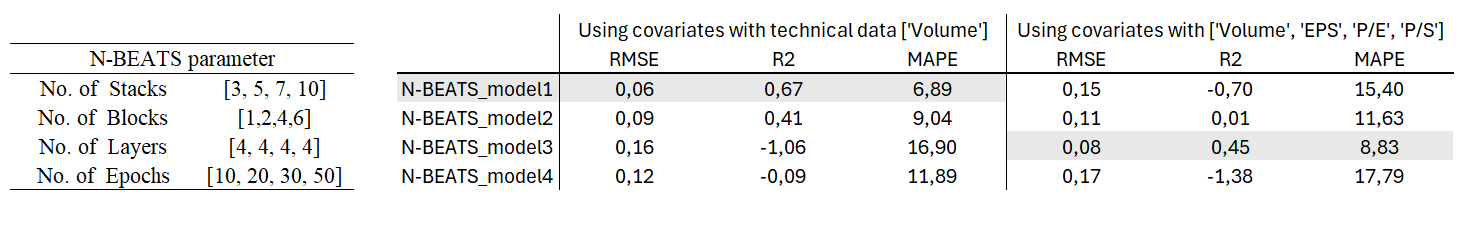

# Only Train with train data

In [4]:
actual_price = scaler.inverse_transform(validation['Close'])

# using train and validation data
past_cov_train = train['Volume']
past_cov_val = validation['Volume']

# using train and validation data
past_cov_train_fn = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val_fn = validation[['Volume', 'EPS', 'P/E', 'P/S']]

In [13]:
# model_par1 define with num_stack is 3, num_blocks is 1, n_epochs is 10
model_par_1 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=3, num_blocks=1, num_layers=4,
    n_epochs=10,
    activation='LeakyReLU'
)
# with covariates[Volume]
model_par_1.fit(train['Close'], past_covariates=past_cov_train)
pred_series = model_par_1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)

# Model Evaluation
print("NBEATS M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 648 K 
---------------------------------------------------
646 K     Trainable params
1.6 K     Non-trainable params
648 K     Total params
2.593     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M1 RMSE = 32.15
NBEATS M1 R2 = 0.10
NBEATS M1 MAPE = 7.32


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 719 K 
---------------------------------------------------
717 K     Trainable params
2.2 K     Non-trainable params
719 K     Total params
2.878     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M1 with FN RMSE = 17.76
NBEATS M1 with FN R2 = 0.73
NBEATS M1 with FN MAPE = 4.38


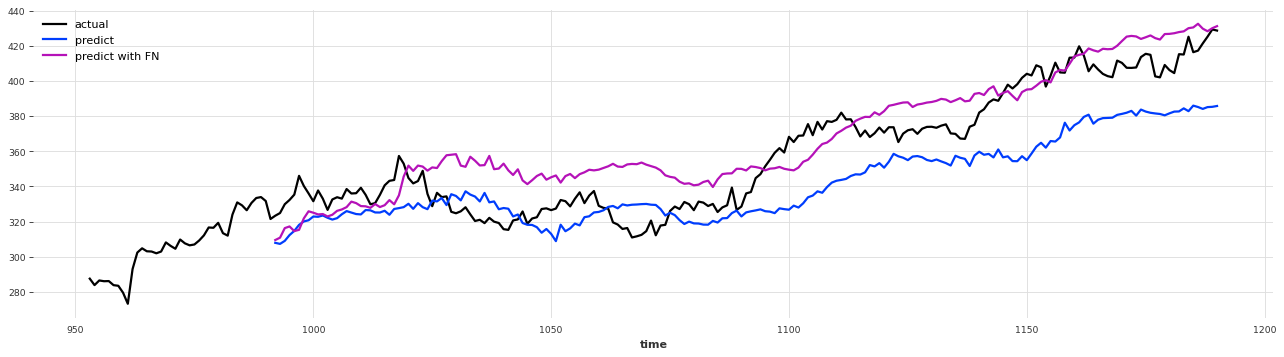

In [17]:
# model_par1 define with num_stack is 3, num_blocks is 1, n_epochs is 10
model_par_1 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=3, num_blocks=1, num_layers=4,
    n_epochs=10,
    activation='LeakyReLU'
)
# with covariates volume and financial data
model_par_1.fit(train['Close'], past_covariates=past_cov_train_fn)
pred_series_fn = model_par_1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price_fn = scaler.inverse_transform(pred_series_fn)

print("NBEATS M1 with FN RMSE = %.2f" % rmse(actual_price, pred_price_fn))
print("NBEATS M1 with FN R2 = %.2f" % r2_score(actual_price, pred_price_fn))
print("NBEATS M1 with FN MAPE = %.2f" % mape(actual_price, pred_price_fn))

# visulation
plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
pred_price_fn.plot(label="predict with FN")
plt.show()

In [18]:
# model_par1 define with num_stack is 3, num_blocks is 1, n_epochs is 10
model_par_2 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=5, num_blocks=2, num_layers=4,
    n_epochs=20,
    activation='LeakyReLU'
)
# with covariates[Volume]
model_par_2.fit(train['Close'], past_covariates=past_cov_train)
pred_series = model_par_2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)

# Model Evaluation
print("NBEATS M2 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS M2 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS M2 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.2 M 
---------------------------------------------------
2.2 M     Trainable params
1.6 K     Non-trainable params
2.2 M     Total params
8.642     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M1 RMSE = 26.62
NBEATS M1 R2 = 0.38
NBEATS M1 MAPE = 6.48


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.4 M 
---------------------------------------------------
2.4 M     Trainable params
2.2 K     Non-trainable params
2.4 M     Total params
9.592     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M2 with FN RMSE = 31.36
NBEATS M2 with FN R2 = 0.15
NBEATS M2 with FN MAPE = 7.16


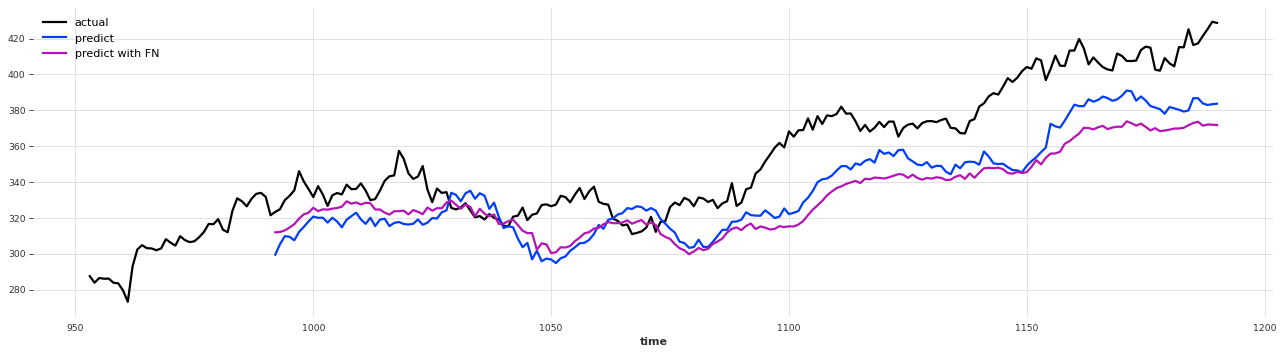

In [19]:
# model_par1 define with num_stack is 3, num_blocks is 1, n_epochs is 10
model_par_2 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=5, num_blocks=2, num_layers=4,
    n_epochs=20,
    activation='LeakyReLU'
)
# with covariates volume and financial data
model_par_2.fit(train['Close'], past_covariates=past_cov_train_fn)
pred_series_fn = model_par_2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price_fn = scaler.inverse_transform(pred_series_fn)

print("NBEATS M2 with FN RMSE = %.2f" % rmse(actual_price, pred_price_fn))
print("NBEATS M2 with FN R2 = %.2f" % r2_score(actual_price, pred_price_fn))
print("NBEATS M2 with FN MAPE = %.2f" % mape(actual_price, pred_price_fn))

# visulation
plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
pred_price_fn.plot(label="predict with FN")
plt.show()

In [5]:
# model_par3 define with num_stack is 7, num_blocks is 4, n_epochs is 30
model_par_3 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=7, num_blocks=4, num_layers=4,
    n_epochs=30,
    activation='LeakyReLU'
)
# with covariates[Volume]
model_par_3.fit(train['Close'], past_covariates=past_cov_train)
pred_series = model_par_3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)

# Model Evaluation
print("NBEATS M3 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS M3 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS M3 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.0 M 
---------------------------------------------------
6.0 M     Trainable params
1.6 K     Non-trainable params
6.0 M     Total params
24.197    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M3 RMSE = 29.80
NBEATS M3 R2 = 0.23
NBEATS M3 MAPE = 7.19


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.7 M 
---------------------------------------------------
6.7 M     Trainable params
2.2 K     Non-trainable params
6.7 M     Total params
26.858    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M3 with FN RMSE = 18.80
NBEATS M3 with FN R2 = 0.69
NBEATS M3 with FN MAPE = 4.45


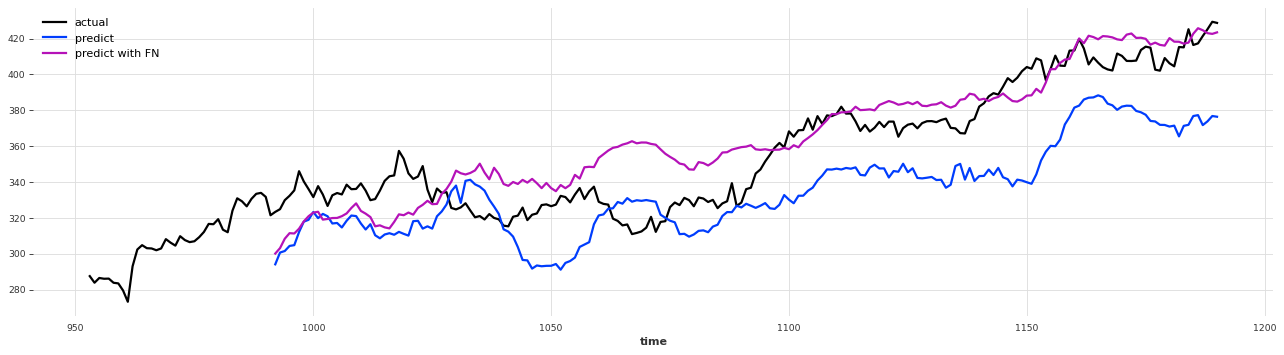

In [6]:
# model_par3 define with num_stack is 7, num_blocks is 4, n_epochs is 30
model_par_3 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=7, num_blocks=4, num_layers=4,
    n_epochs=30,
    activation='LeakyReLU'
)
# with covariates volume and financial data
model_par_3.fit(train['Close'], past_covariates=past_cov_train_fn)
pred_series_fn = model_par_3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price_fn = scaler.inverse_transform(pred_series_fn)

print("NBEATS M3 with FN RMSE = %.2f" % rmse(actual_price, pred_price_fn))
print("NBEATS M3 with FN R2 = %.2f" % r2_score(actual_price, pred_price_fn))
print("NBEATS M3 with FN MAPE = %.2f" % mape(actual_price, pred_price_fn))

# visulation
plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
pred_price_fn.plot(label="predict with FN")
plt.show()

In [7]:
# model_par4 define with num_stack is 10, num_blocks is 6, n_epochs is 50
model_par_4 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=10, num_blocks=6, num_layers=4,
    n_epochs=50,
    activation='LeakyReLU'
)
# with covariates[Volume]
model_par_4.fit(train['Close'], past_covariates=past_cov_train)
pred_series = model_par_4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)

# Model Evaluation
print("NBEATS M4 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS M4 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS M4 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 13.0 M
---------------------------------------------------
13.0 M    Trainable params
1.6 K     Non-trainable params
13.0 M    Total params
51.850    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M4 RMSE = 27.97
NBEATS M4 R2 = 0.32
NBEATS M4 MAPE = 6.47


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 14.4 M
---------------------------------------------------
14.4 M    Trainable params
2.2 K     Non-trainable params
14.4 M    Total params
57.552    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS M4 with FN RMSE = 38.72
NBEATS M4 with FN R2 = -0.30
NBEATS M4 with FN MAPE = 7.91


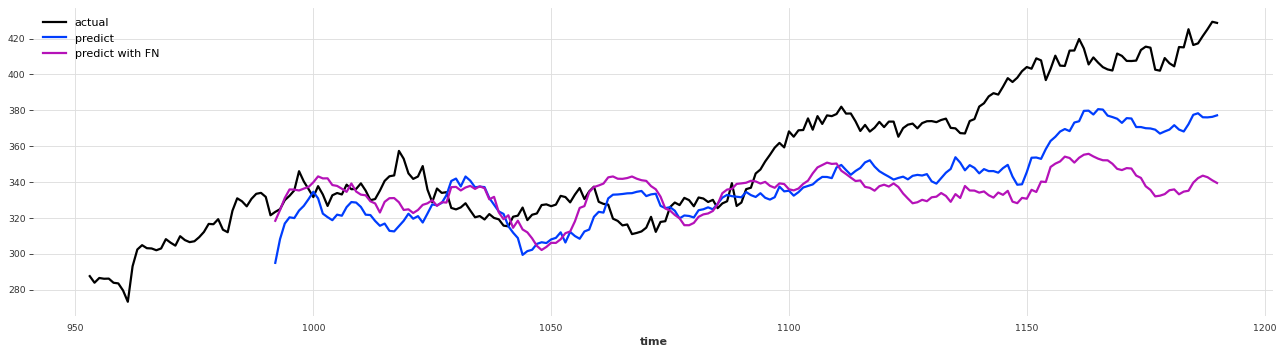

In [8]:
model_par_4 = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=10, num_blocks=6, num_layers=4,
    n_epochs=50,
    activation='LeakyReLU'
)
# with covariates volume and financial data
model_par_4.fit(train['Close'], past_covariates=past_cov_train_fn)
pred_series_fn = model_par_4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price_fn = scaler.inverse_transform(pred_series_fn)

print("NBEATS M4 with FN RMSE = %.2f" % rmse(actual_price, pred_price_fn))
print("NBEATS M4 with FN R2 = %.2f" % r2_score(actual_price, pred_price_fn))
print("NBEATS M4 with FN MAPE = %.2f" % mape(actual_price, pred_price_fn))

# visulation
plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
pred_price_fn.plot(label="predict with FN")
plt.show()